In [84]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [160]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [188]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get Shapes from database

In [146]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [151]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))

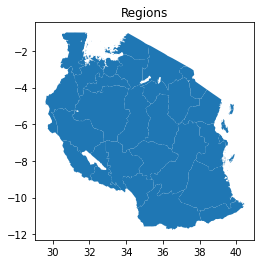

In [152]:
regions_gdf.plot()
plt.title('Regions')
plt.show()

# Load data for single shape

In [77]:
shape_gdf = regions_gdf[regions_gdf['name'] == 'Dar-es-salaam'].reset_index(drop=True)
shape_id = shape_gdf.at[0, 'id']

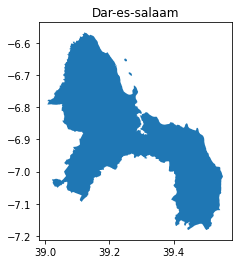

In [81]:
shape_gdf.plot()
plt.title(shape_gdf.at[0, 'name'])
plt.show()

In [112]:
q = {
    'filter_parameters': ','.join(['worldpop_popc']), # list of parameters, 
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/shape/{shape_id}?{urlencode(q)}", auth=auth).json()
shape_df = pd.DataFrame(d['data'])

In [113]:
shape_df

,worldpop_popc_sum,year
0,4294334.0,2011
1,4554449.0,2012
2,4829976.0,2013
3,5121146.0,2014
4,5428955.0,2015
5,5753794.0,2016
6,6097105.5,2017
7,6459003.0,2018
8,6840113.0,2019
9,7239773.0,2020


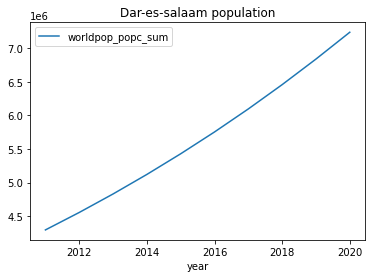

In [114]:
shape_df.plot(x='year', y=['worldpop_popc_sum'])
plt.title(f"{shape_gdf.at[0, 'name']} population")
plt.show()

# Load all data for given parameter for all shapes

In [140]:
parameter_id = 'worldpop_popc'
q = {
    'start_date': '2010', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
param_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

In [141]:
# print available fields
print(d['fields'])

['worldpop_popc_sum']


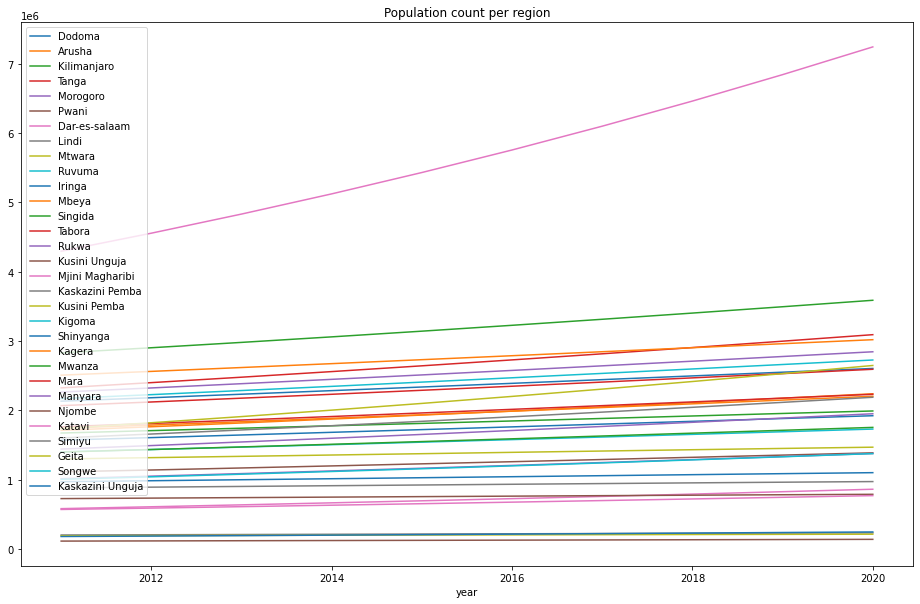

In [143]:
fig, ax = plt.subplots(figsize=(16, 10))

for sid in shape_ids:
    # only build charts for known id's from above
    if sid not in regions.keys():
        continue
    
    dfx = param_df[param_df['shape_id'] == sid]
    dfx.plot(x='year', y='worldpop_popc_sum', ax=ax, label=regions[sid])
    
plt.title('Population count per region')
plt.show()

# Load perc. and Dengue cases for all shapes 

In [189]:
parameter_id = 'chirps_tprecit'
q = {
    'start_date': '2018', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
chirps_tprecit_df = pd.DataFrame(d['data'])
chirps_tprecit_df['date'] = pd.to_datetime(chirps_tprecit_df['date'])

In [206]:
parameter_id = 'lit_dengue_out_loc'
q = {
    'start_date': '2018', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
lit_dengue_out_loc_df = pd.DataFrame(d['data'])
lit_dengue_out_loc_df['date'] = pd.to_datetime(lit_dengue_out_loc_df['date'])

In [204]:
d['fields']

['lit_dengue_out_loc_id',
 'lit_dengue_out_loc_cases',
 'lit_dengue_out_loc_confirmed_cases',
 'lit_dengue_out_loc_deaths',
 'lit_dengue_out_loc_start_date',
 'lit_dengue_out_loc_end_date']

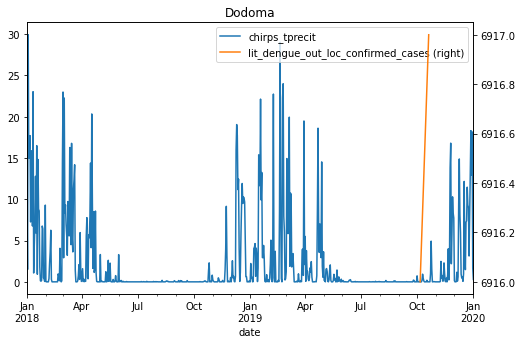

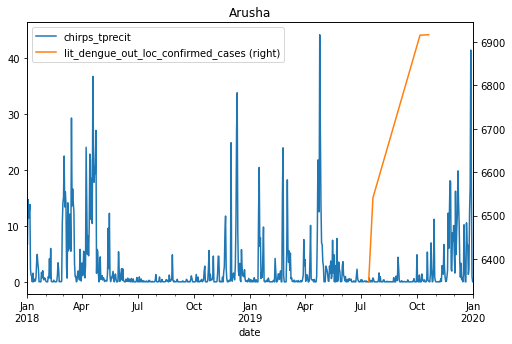

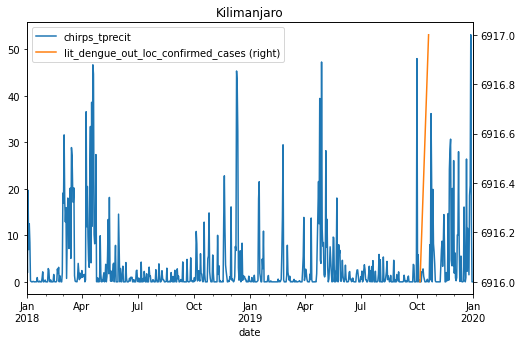

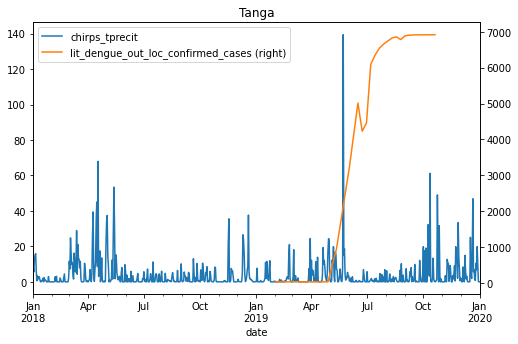

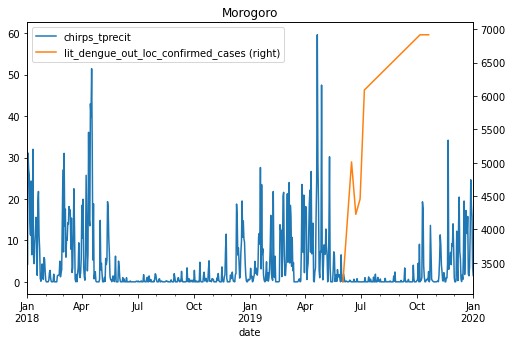

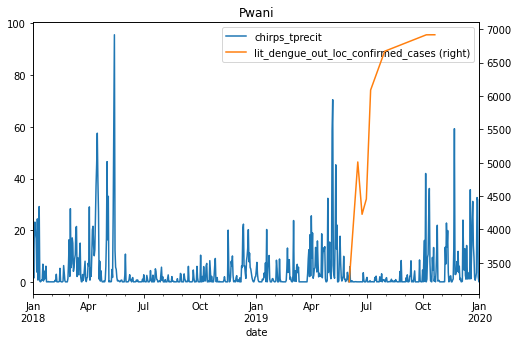

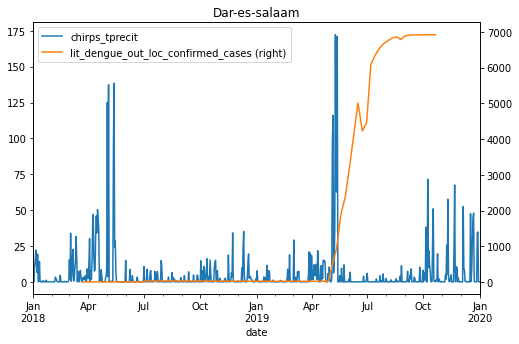

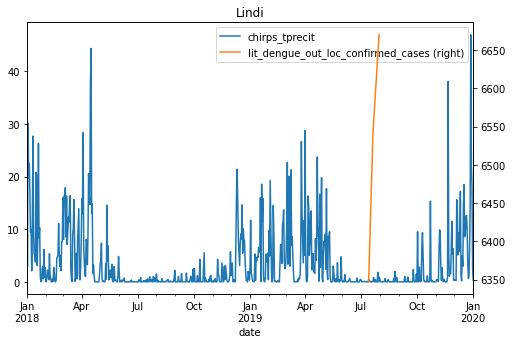

No cases for Mtwara.


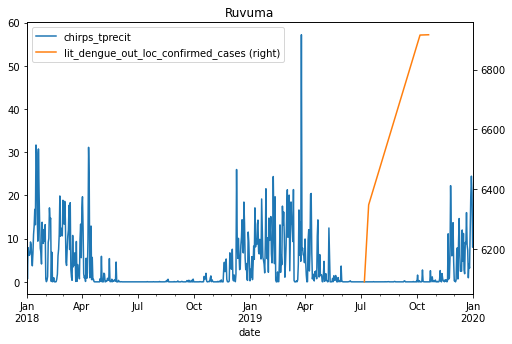

No cases for Iringa.
No cases for Mbeya.


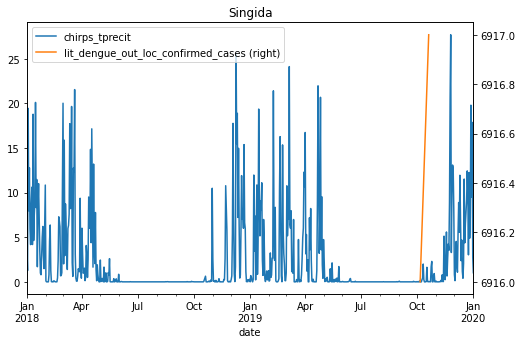

No cases for Tabora.
No cases for Rukwa.
No cases for Kusini Unguja.
No cases for Mjini Magharibi.
No cases for Kaskazini Pemba.
No cases for Kusini Pemba.
No cases for Kigoma.
No cases for Shinyanga.


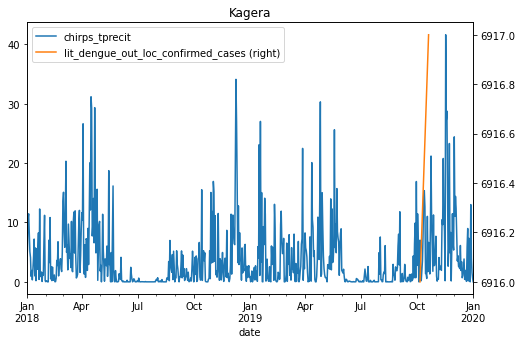

No cases for Mwanza.
No cases for Mara.
No cases for Manyara.
No cases for Njombe.
No cases for Katavi.
No cases for Simiyu.
No cases for Geita.
No cases for Songwe.
No cases for Kaskazini Unguja.


In [209]:
for sid in shape_ids:
    # only build charts for known id's from above
    if sid not in regions.keys():
        continue
        
    # tprecit 
    dfx_tprecit = chirps_tprecit_df[chirps_tprecit_df['shape_id'] == sid].reset_index(drop=True)
    if len(dfx_tprecit) == 0:
        print(f"No prec. for {regions[sid]}.")
        continue
        
    # cases 
    dfx_cases = lit_dengue_out_loc_df[lit_dengue_out_loc_df['shape_id'] == sid].reset_index(drop=True)
    if len(dfx_cases) == 0:
        print(f"No cases for {regions[sid]}.")
        continue
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    dfx_tprecit.plot(x='date', y='chirps_tprecit', ax=ax)
    dfx_cases.plot(x='date', y='lit_dengue_out_loc_confirmed_cases', ax=ax, secondary_y=True)

    
    plt.title(regions[sid])
    plt.show()